# Demo 1: Linear Regression

In this demo we will show:
* Linear regression using the closed form solution and gradient descent. 
* Adaptive Learning rates.
* Gradient descent to minimize other (non-convex) functions. 
* Linear regression on polynomials.
* A real life example on Diabetes

In [6]:
# Code source: Sebastian Curi and Andreas Krause, based on Jaques Grobler (sklearn demos).
# License: BSD 3 clause

# We start importing some modules and running some magic commands
% matplotlib inline
% reload_ext autoreload
% load_ext autoreload
% autoreload 2

# General math and plotting modules.
import numpy as np
import matplotlib.pyplot as plt

# Project files.
from util import gradient_descent, generate_polynomial_data
import plot_helpers
from regressors import LinearRegressor
from regularizers import Regularizer, L2Regularizer

# Widget and formatting modules
import ipywidgets
from ipywidgets import interact, interactive, interact_manual
import pylab
# If in your browser the figures are not nicely vizualized, change the following line. 
pylab.rcParams['figure.figsize'] = (10, 5)

# Machine Learning library. 

import sklearn
from sklearn import datasets, linear_model
from sklearn.datasets import make_regression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')
# from sklearn import datasets, linear_model


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Linear regression 

We will start by fitting by linear regression a set of data points of the type $D = \left\{(x, y)_i\right\}$, $i = 1, 2, \ldots, n$.

The objective of linear regression, is to find coefficents $\hat{w}$ such that the residual between $\hat{y} = \hat{w}^\top \tilde{x}$, and $y$ is small. (Remember that $\tilde{x} = [x, 1]$). From now on, $x$ will be considered the extended version unless stated otherwise, hence dropping the tilde notation. 

The goodness of fit in Linear regression is usually calculated as the sum of squared residuals, but other loss functions are also available. 

The risk function is defined as: $$ R(\hat{w}) = \mathbb{E}[\frac{1}{2}(y-\hat{w}^\top x)^2)]$$
where the expectation is taken over the data generating the distribution of points. As the whole data generating distribution is not known, the expectation is approximated by samples from the **training** set. 

The risk is approximated by the empirical risk as:
$$ R(\hat{w}) \approx \hat{R}(\hat{w}) \frac{1}{n} \sum_{i=1}^n (y_i - \hat{w}^\top x_i)^2.$$ 


By grouping the data into the feature matrix $X$ and target matrix $Y$, such that:

$$ X = \left[ \begin{array}{cc} x_1^\top & 1\\ x_2^\top & 1 \\ \vdots & \vdots \\ x_n^\top & 1  \end{array}\right]$$
$$ Y = \left[ \begin{array}{c} y_1\\ y_2 \\ \vdots \\ y_n  \end{array}\right].$$ 

The empirical risk function can be expressed as:
$$\hat{R}(\hat{w})= \frac{1}{n}(X\hat{w} - Y)^\top (X\hat{w} - Y) $$


### Closed form solution

The closed form solution to the regression problem is given by:
$$\hat{w} = (X^\top X)^{-1} X^T y.$$ 

The closed form can be computed with a total number of operations given by $\approx O(d^3+nd^2)$ .

### Gradient Descent

When the number of dimensions or examples grows, the closed form solution becomes expensive to compute. However, the parameters $\hat{w}$ can be updated via a gradient descent rule: 

$$ \hat{w}_{t+1} \gets \hat{w}_t - \eta_t \left.\frac{\partial \hat{R} }{\partial \hat{w}} \right|_{w=w_t},$$

where $\eta_t$ is a parameter of the algorithm, $k$ is the iteration index, and $\frac{\partial \hat{R}}{\partial \hat{w}}$

The gradients of $\hat{R}$ with respect to the parameters are:

$$ \frac{\partial \hat{R} }{\partial \hat{w}} = \frac{1}{} X^\top(Xw - y) $$ 
In the *vanilla* gradient descent method, $\eta(k)=\eta_0$ is a constant. However other algorithms exists that modify this. We will discuss these later. 

The computational complexity of Gradient descent is $O(n_{\text{iter}} \cdot  n d)$. 

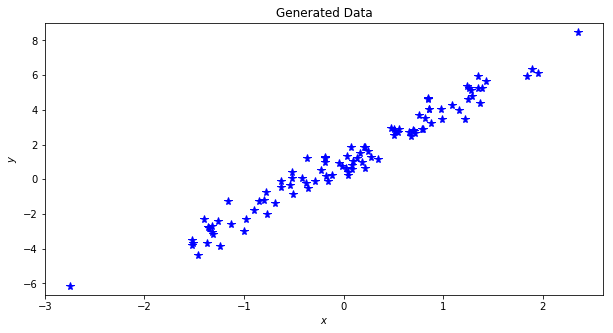

In [7]:
# Generate the data.

num_points = 100  # Number of training points.
noise = 0.6  # Noise Level (needed for data generation).

a_true = 3  # Slope.
b_true = 1  # Intercept. 
w_true = np.array([a_true, b_true])

X, Y = generate_polynomial_data(num_points, noise, w_true)

# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated Data', 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)

## Closed Form Solution:

The closed form solution to the regression problem is given by:
$$\hat{w} = (X^\top X + \lambda I_d)^{-1} X^T y.$$ 

Because there are only 2 parameters, the inverse of $(X^\top X + \lambda I_d)$ is fast to do $\approx O(d^3)$. Hence, the closed form can be computed with a total number of operations given by $\approx O(d^3+nd^2)$ .

In [9]:
def change_reg_coefficient(reg):
    dim = X.shape[1]
    w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X.T, X) + np.power(10., reg) * np.eye(dim)), np.dot(X.T, Y))
    print("w_hat = {}".format(w_hat_closed_form))
    # Plot closed form solution
    fig = plt.subplot(111)
    plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True,
                 'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}

    plot_helpers.plot_data(X[:, 0], Y, fig=fig, options=plot_opts)
    plot_helpers.plot_fit(X, w_hat_closed_form, fig=fig, options=plot_opts)

interact(change_reg_coefficient,
         reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False));


interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

In [11]:
# Gradient Descent solution. 

def change_learning_params(eta0, n_iter, reg=0):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(np.power(10., reg))
    w0 = np.array([0., 0.])
    opts = {'eta0': eta0, 'n_iter': n_iter, 'n_samples': X.shape[0]}
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False,
                   }
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False, 
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_learning_params,
                eta0=ipywidgets.FloatSlider(value=1e-1,
                                            min=1e-1,
                                            max=2,
                                            step=1 * 1e-1,
                                            readout_format='.1f',
                                            description='Learning rate:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=20,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                reg=ipywidgets.FloatSlider(value=-3,
                                           min=-3,
                                           max=1,
                                           step=0.5,
                                           readout_format='.2f',
                                           description='Regularization 10^:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                );


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='Learning rate:', max=2.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=20, min=5, style=SliderStyle(description_width='initial')), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=1.0, min=-3.0, step=0.5, style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Adaptive Learning rates. 

* Annealing 
    $\eta_{t} = \frac{\eta_0}{(1+t)^{0.6}}$

* Bold driver heuristic:

    If $\hat{R}(\hat{w}_t) > \hat{R}(\hat{w}_{t+1})$, 
    
    $\eta_{t+1} = \eta_{t}/5$
    
    else
    
    $\eta_{t+1} \gets \eta_{t}*1.1$

    
* AdaGrad:
    $\eta_t = \frac{\eta_0}{\sqrt{\sum_{j=0}^t g_j^2}}$, where $g_j$ is the 2-norm gradient of $L$ at time $j$. 

       
        

In [12]:
def change_heuristics(learning_rate_scheduling=None):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(0)
    w0 = np.array([0., 0.])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': 2,
            'n_iter': 10,
            'n_samples': X.shape[0],
            'algorithm': 'GD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(121)
    dataplot = plt.subplot(122)
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_opts = {'contour_opts': contour_opts, 'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)

interact_manual(change_heuristics,
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='Bold driver',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'})
                );

interactive(children=(RadioButtons(description='Learning rate heuristics:', options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='Bold driver'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Gradient descent to minimize other (non-convex) functions.

Gradient descent works can be used as a minimizing algorithm for other functions, even if they are non-convex. Gradient descent, if it converges, converges to a local minimum. Lets look at the function $$f(w) = \sin(w_0)\cos(w_1).$$ We would like to find parameters $(a,b)$ that minimize the function $f$. 

The gradients are:
$$\frac{\partial f}{\partial w_0} =  \cos(w_0)\cos(w_1),$$
$$\frac{\partial f}{\partial w_1} = -\sin(w_0)\sin(w_1).$$

In [6]:
class sincos(object):
    def __init__(self):
        pass

    def get_number_samples(self):
        return 0

    def loss(self, w, *args):
        return np.sin(w[0]) * np.cos(w[1])

    def gradient(self, w, *args):
        return np.array([np.cos(w[0]) * np.cos(w[1]), -np.sin(w[0]) * np.sin(w[1])])

def optimize_sincos(eta, n_iter, learning_rate_scheduling, a0, b0):
    regressor = sincos()
    regularizer = L2Regularizer(0)
    w0 = np.array([a0, b0])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': eta,
            'n_iter': n_iter,
            'n_samples': 0,
            'algorithm': 'GD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = plt.subplot(111)
    dataplot = None
    contour_opts = {'x_label': '$w_0$', 'y_label': '$w_1$', 'title': 'Weight trajectory', 'legend': False}
    plot_opts = {'contour_opts': contour_opts}

    plot_helpers.linear_regression_progression(np.array([]), np.array([]), trajectory, indexes, regressor.loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(optimize_sincos,
                eta=ipywidgets.FloatSlider(value=4,
                                           min=1e-1,
                                           max=10,
                                           step=1e-1,
                                           readout_format='.1f',
                                           description='Learning rate:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='None',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'}),
                a0=ipywidgets.FloatSlider(value=-0.9,
                                          min=-3,
                                          max=3,
                                          step=.1,
                                          readout_format='.1f',
                                          description='w_0:',
                                          style={'description_width': 'initial'},
                                          continuous_update=False),
                b0=ipywidgets.FloatSlider(value=1.1,
                                          min=-3,
                                          max=3,
                                          step=.1,
                                          readout_format='.1f',
                                          description='w_1:',
                                          style={'description_width': 'initial'},
                                          continuous_update=False));

interactive(children=(FloatSlider(value=4.0, continuous_update=False, description='Learning rate:', max=10.0, min=0.1, readout_format='.1f', style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), RadioButtons(description='Learning rate heuristics:', index=3, options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='None'), FloatSlider(value=-0.9, continuous_update=False, description='w_0:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), FloatSlider(value=1.1, continuous_update=False, description='w_1:', max=3.0, min=-3.0, readout_format='.1f', style=SliderStyle(description_width='initial')), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Linear regression on polynomials.

Higher order features can be constructed from data $D = \left\{(x, y)_i\right\}$, $i = 1, 2, \ldots, n$. For example cubic polynomial features can be created by forming the data and target matrices as:

$$ X = \left[ \begin{array}{cccc} x_1^3 & x_1^2 & x_1 & 1\\ x_2^3 & x_2^2 & x_2 & 1 \\ \vdots & \vdots \\ x_n^3 & x_n^2 & x_n & 1  \end{array}\right]$$
$$ Y = \left[ \begin{array}{c} y_1\\ y_2 \\ \vdots \\ y_n  \end{array}\right].$$ 

The predictor is again of the form $\hat{Y} = X\hat{w}$. Even if the features in the data matrix $X$ are non-linear on the data, the estimator is linear on the parameters $\hat{w}$. Hence, the empirical risk function is again:
$$\hat{R}(\hat{w})= \frac{1}{n}(X\hat{w} - Y)^\top (X\hat{w} - Y),$$

and linear regression problem is identical as in the previous example.

In [13]:
# Generate the data and calculate the close form solution

num_points = 100  # Number of training points.
noise = 0.3  # Noise Level (needed for data generation).

w_true = np.array([-.5, .5, 1, -1])
X, Y = generate_polynomial_data(num_points, noise, w_true)

def change_reg_coefficient(reg):
    dim = X.shape[1]
    w_hat_closed_form = np.dot(np.linalg.pinv(np.dot(X.T, X) + np.power(10., reg) * np.eye(dim)), np.dot(X.T, Y))
    # 

    # Plot closed form solution
    fig = plt.subplot(111)
    plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed Form Solution', 'legend': True, 
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_helpers.plot_data(X[:, -2], Y, fig=fig, options=plot_opts)
    plot_helpers.plot_fit(X, w_hat_closed_form, fig=fig, options=plot_opts)
    
    print("w_hat = {}".format(w_hat_closed_form))

interact(change_reg_coefficient,
         reg=ipywidgets.FloatSlider(value=-3,
                                    min=-3,
                                    max=3,
                                    step=0.5,
                                    readout_format='.1f',
                                    description='Regularization 10^:',
                                    style={'description_width': 'initial'},
                                    continuous_update=False));


interactive(children=(FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

In [16]:
def optimize_cubic(eta, n_iter, reg, learning_rate_scheduling):
    regressor = LinearRegressor(X, Y)
    regularizer = L2Regularizer(np.power(10., reg))
    w0 = np.array([0., 0., 0., 0.])
    if learning_rate_scheduling == 'None':
        learning_rate_scheduling = None

    opts = {'eta0': eta,
            'n_iter': n_iter,
            'n_samples': X.shape[0],
            'algorithm': 'GD',
            'learning_rate_scheduling': learning_rate_scheduling
            }
    trajectory, indexes = gradient_descent(w0, regressor, regularizer, opts)

    contourplot = None
    dataplot = plt.subplot(111)
    data_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Regression trajectory', 'legend': False,
                'y_lim': [np.min(Y)-0.5, np.max(Y)+0.5]}
    plot_opts = {'data_opts': data_opts}

    plot_helpers.linear_regression_progression(X, Y, trajectory, indexes, regressor.test_loss,
                                               contourplot, dataplot, options=plot_opts)


interact_manual(optimize_cubic,
                eta=ipywidgets.FloatSlider(value=1e-2,
                                           min=1e-3,
                                           max=1,
                                           step=1e-3,
                                           readout_format='.3f',
                                           description='Learning rate:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                n_iter=ipywidgets.IntSlider(value=10,
                                            min=5,
                                            max=50,
                                            step=1,
                                            description='Number of iterations:',
                                            style={'description_width': 'initial'},
                                            continuous_update=False),
                reg=ipywidgets.FloatSlider(value=-3,
                                           min=-3,
                                           max=3,
                                           step=0.5,
                                           readout_format='.1f',
                                           description='Regularization 10^:',
                                           style={'description_width': 'initial'},
                                           continuous_update=False),
                learning_rate_scheduling=ipywidgets.RadioButtons(
                    options=['Bold driver', 'AdaGrad', 'Annealing', 'None'],
                    value='None',
                    description='Learning rate heuristics:',
                    style={'description_width': 'initial'})
                );

interactive(children=(FloatSlider(value=0.01, continuous_update=False, description='Learning rate:', max=1.0, min=0.001, readout_format='.3f', step=0.001, style=SliderStyle(description_width='initial')), IntSlider(value=10, continuous_update=False, description='Number of iterations:', max=50, min=5, style=SliderStyle(description_width='initial')), FloatSlider(value=-3.0, continuous_update=False, description='Regularization 10^:', max=3.0, min=-3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), RadioButtons(description='Learning rate heuristics:', index=3, options=('Bold driver', 'AdaGrad', 'Annealing', 'None'), style=DescriptionStyle(description_width='initial'), value='None'), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

## Choosing the Polynomial Order.

If the order of the polynomial is not known, then how should we select it? **Answer**: Cross-validation!

In [17]:
def f(x):
    return x * np.sin(x) 

x_plot = np.linspace(-1, 11, 100)
f_plot = f(x_plot)
X_plot = x_plot[:, np.newaxis]

def resample(noise):
    N = 20
    folds = 5
    n = int(N/folds)

    xraw = np.linspace(0, 10, N)
    # rng = np.random.RandomState(0)
    np.random.shuffle(xraw)

    #noise=1

    x = dict()
    y = dict()
    for i in range(folds):
        x[i] = xraw[n*i:n*(i+1)]
        y[i] = f(x[i]) + np.random.normal(size=(n,)) * noise

    
    def change_degree(degree, reg, fold):
        X = np.array(())
        Y = np.array(())
        for i in range(5):
            if i == (fold-1):
                Xval = x[i]
                Yval = y[i]
            else:
                X = np.concatenate((X, x[i]))
                Y = np.concatenate((Y, y[i]))


        X = X[:, np.newaxis]
        Xval = Xval[:, np.newaxis]

        model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=np.power(10., reg)))

        model.fit(X, Y)
        
        fig = plt.subplot(111)
        lw = 2
        plt.plot(x_plot, f_plot, color='cornflowerblue', linewidth=lw, label="Ground Truth")
        y_plot = model.predict(X_plot)
        plt.plot(x_plot, y_plot, color='r', linewidth=lw, label="Degree %d" % degree)
        
        opts = {'marker': 'b*', 'label': 'Training Points'}
        plot_helpers.plot_data(X, Y, fig=fig, options=opts)
        
        plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'y_lim': [np.min(f_plot)-3, np.max(f_plot)+3], 
                     'legend':True, 'legend_loc': 'lower left'}
        opts = {'marker': 'mX', 'label': 'Validation Points'}
        plot_opts.update(opts)
        plot_helpers.plot_data(Xval, Yval, fig=fig, options=plot_opts)
        
        print("Train. Error: {:.2f}".format(1/X.size * np.linalg.norm(model.predict(X) - Y, 2)))
        print("Valid. Error: {:.2f}".format(1/Xval.size * np.linalg.norm(model.predict(Xval) - Yval, 2)))
        
        
    interact(change_degree,
             degree=ipywidgets.IntSlider(value=1,
                                         min=1,
                                         max=15,
                                         step=1,
                                         description='Polynomial Degree:',
                                         style={'description_width': 'initial'},
                                         continuous_update=False),
             reg=ipywidgets.FloatSlider(value=-3,
                                               min=-3,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Regularization 10^:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),
             fold=ipywidgets.ToggleButtons(value=1,
                                        options=[1, 2, 3, 4, 5],
                                         description='Validation fold:',
                                         style={'description_width': 'initial'},
                                         continuous_update=False),);

interact(resample, noise=ipywidgets.FloatSlider(value=1,
                                               min=0,
                                               max=3,
                                               step=0.5,
                                               readout_format='.1f',
                                               description='Noise level:',
                                               style={'description_width': 'initial'},
                                               continuous_update=False),);

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Noise level:', max=3.0, readout_format='.1f', step=0.5, style=SliderStyle(description_width='initial')), Output()), _dom_classes=('widget-interact',))

## Real data sets: Diabetes prediction

In this example we will use a diabetes dataset from sklearn. First we will split into train and test data to evaluate the prediction performance. Then a linear regressor using only one feature will be evaluated. In the second cell, a linear regressor using all the features but with no feature transformation is implemented. Finally, a 5th order polynomial transformation on the single feature used in the first cell is evaluated.

In [18]:
# Load the diabetes dataset
diabetes = datasets.load_diabetes()

Y_all = diabetes.target
X_all = scale(diabetes.data) # zero mean unit variance
n_all = Y_all.size
n_test = 20

# Split the data into training/testing sets
X_train = X_all[:-n_test]
X_test = X_all[-n_test:]

# Split the targets into training/testing sets
Y_train = Y_all[:-n_test]
Y_test = Y_all[-n_test:]

Coefficients: 
 [ 33.73295272]
Mean squared error: 4058.41
Explained variance: 0.16


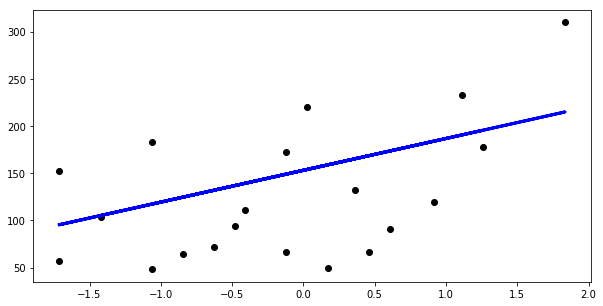

In [19]:
# Now let's train a 1D linear regression based on a single feature

use_feature = 3
# Use only one feature

X_train_1D = X_train[:, np.newaxis, use_feature]
X_test_1D = X_test[:, np.newaxis, use_feature]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training set
regr.fit(X_train_1D, Y_train)

# Make predictions on the testing set
Y_pred = regr.predict(X_test_1D)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Explained variance: %.2f' % r2_score(Y_test, Y_pred))

# Plot outputs
plt.scatter(X_test_1D, Y_test,  color='black')
plt.plot(X_test_1D, Y_pred, color='blue', linewidth=3)

plt.show()

Coefficients: 
 [  1.44360014e-02  -1.13033495e+01   2.42834645e+01   1.55888584e+01
  -3.87242964e+01   2.34407995e+01   4.89200200e+00   8.78083524e+00
   3.53656217e+01   3.61947824e+00]
Mean squared error: 2004.57
Explained variance: 0.59


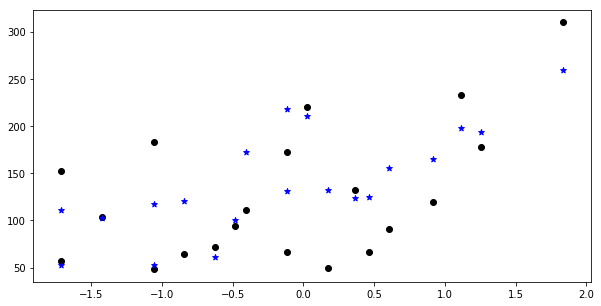

In [20]:
# Now let's use all features

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Explained variance: %.2f' % r2_score(Y_test, Y_pred))

# Plot outputs
plt.scatter(X_test_1D, Y_test,  color='black')
plt.scatter(X_test_1D, Y_pred, color='blue', marker='*')

plt.show()

Coefficients: 
 [  0.          32.39842197  13.12177699  -0.36124814  -2.5108258
   0.25200116]
Mean squared error: 3799.76
Explained variance: 0.21


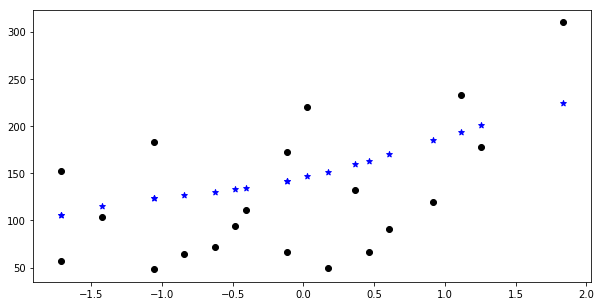

In [21]:
# Now let's use all features

# Create linear regression object
regr = linear_model.LinearRegression()

PF = PolynomialFeatures(degree=5, interaction_only=False, include_bias=True)

X_train_poly = PF.fit_transform(X_train_1D)
X_test_poly = PF.fit_transform(X_test_1D)


# Train the model using the training sets
regr.fit(X_train_poly, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test_poly)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_test, Y_pred))
# Explained variance score: 1 is perfect prediction
print('Explained variance: %.2f' % r2_score(Y_test, Y_pred))

# Plot outputs
plt.scatter(X_test_1D, Y_test,  color='black')
plt.scatter(X_test_1D, Y_pred, color='blue', marker='*')

plt.show()